In [1]:
STUDIO_DIR = "../../dataset/studio"
LIVE_DIR = "../../dataset/live"

In [2]:
import whisper

model = whisper.load_model("small")

In [3]:
import os
import librosa

studio_files = sorted(os.listdir(STUDIO_DIR))
live_files = sorted(os.listdir(LIVE_DIR))

matching_files = []
for studio_file in studio_files:
    if studio_file in live_files:
        matching_files.append(studio_file)
        break  # only the first match

if matching_files:
    print("First matching file:", matching_files[0])
    studio_audio_path = os.path.join(STUDIO_DIR, matching_files[0])
    studio_audio, studio_sr = librosa.load(studio_audio_path, sr=None)
    print(f"Loaded studio audio: {studio_audio_path}, Sample rate: {studio_sr}")

    live_audio_path = os.path.join(LIVE_DIR, matching_files[0])
    live_audio, live_sr = librosa.load(live_audio_path, sr=None)
    print(f"Loaded live audio: {live_audio_path}, Sample rate: {live_sr}")
else:
    print("No matching files found.")

First matching file: After Hours.mp3
Loaded studio audio: ../../dataset/studio/After Hours.mp3, Sample rate: 48000
Loaded live audio: ../../dataset/live/After Hours.mp3, Sample rate: 48000


In [4]:
print("Transcribing studio audio...")
studio_result = model.transcribe(
    studio_audio_path, 
    language='en', 
    fp16=False,
    word_timestamps=True, 
    verbose=False
)

print("Studio audio transcription:")
print("Full text:", studio_result['text'])
print("\nSegments with timestamps:")
for i, segment in enumerate(studio_result['segments']):
    start_time = segment['start']
    end_time = segment['end']
    text = segment['text']
    print(f"Segment {i+1}: [{start_time:.2f}s - {end_time:.2f}s] '{text.strip()}'")

if 'words' in studio_result['segments'][0]:
    print("\nWord-level timestamps (first 10 words):")
    word_count = 0
    for segment in studio_result['segments']:
        if 'words' in segment:
            for word in segment['words']:
                if word_count < 10:
                    print(f"  '{word['word']}' [{word['start']:.2f}s - {word['end']:.2f}s]")
                    word_count += 1
                else:
                    break
        if word_count >= 10:
            break

print("\n" + "="*60)

print("Transcribing live audio...")
live_result = model.transcribe(
    live_audio_path, 
    language='en', 
    fp16=False,
    word_timestamps=True, 
    verbose=False
)

print("Live audio transcription:")
print("Full text:", live_result['text'])
print("\nSegments with timestamps:")
for i, segment in enumerate(live_result['segments']):
    start_time = segment['start']
    end_time = segment['end']
    text = segment['text']
    print(f"Segment {i+1}: [{start_time:.2f}s - {end_time:.2f}s] '{text.strip()}'")

if 'words' in live_result['segments'][0]:
    print("\nWord-level timestamps (first 10 words):")
    word_count = 0
    for segment in live_result['segments']:
        if 'words' in segment:
            for word in segment['words']:
                if word_count < 10:
                    print(f"  '{word['word']}' [{word['start']:.2f}s - {word['end']:.2f}s]")
                    word_count += 1
                else:
                    break
        if word_count >= 10:
            break

Transcribing studio audio...


100%|██████████| 36192/36192 [00:07<00:00, 4812.20frames/s]


Studio audio transcription:
Full text:  I thought I almost died in my dream again Fighting for my life, I couldn't breathe again I'm falling into blue Without your notice, blue Cause my heart belongs to you I'm risking it all for you I want you to leave this time I'll never believe I don't wanna share the babies Protection we won't need You're falling next to me It's just a memory I'm falling today Without your honesty It's only our delirium I'm trying to leave I'm just giving it My darkest hours Fell apart from my loneliness out of this crowded room Different curves on the flight is wrapped in my thoughts of you I turned into the man I used to be I myself asleep Just so I can get closer to you inside my dreams You didn't wanna wake up and see what's inside me I just wanted to call you and say And say Oh baby Where are you now and I need you most I'd give it all just to hold you close Sorry that I broke your heart Your heart Never coming down I was running away from peace in reality Wa

100%|██████████| 26791/26791 [00:04<00:00, 5501.96frames/s]


Live audio transcription:
Full text:  Oh baby I'm falling into deep I'm falling into deep Oh baby I'm falling into deep My darkness I was A girl I felt so alone inside of this crowded roof Deeper girls on the floor distracted my thoughts again I turned into the memories to be To be Who I selfishly Chose so I can get closer to you inside my dreams Didn't wanna wake up as you would be so angry I just wanted to guide you and say And say Oh baby Well I am now and I need you close I give it all just to hold you close Sorry that I broke your heart Your heart Never coming down I was running away from this reality Wasting all of my time I live in my fantasies Spending money to compensate Compensate Cause I want you baby I be living in heaven when I'm inside of you It was simply a pleasure when you've been so few I never let you down again Again Oh baby Well I am now and I need you close I give it all just to hold you close Sorry that I broke your heart Your heart I say baby I dream too better 

In [5]:
import re
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def preprocess_lyrics(text):
    """Clean and normalize lyrics for comparison."""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(oh|ah|yeah|no)\b', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def calculate_sequence_similarity(text1, text2):
    """Calculate similarity using sequence matching."""
    return SequenceMatcher(None, text1, text2).ratio()

def calculate_tfidf_similarity(text1, text2):
    """Calculate similarity using TF-IDF vectors."""
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
    try:
        tfidf_matrix = vectorizer.fit_transform([text1, text2])
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        return similarity
    except ValueError:
        return 0.0

def extract_key_phrases(text, num_phrases=10):
    """Extract key phrases from lyrics."""
    words = text.split()
    phrases = []
    
    for n in range(2, 5):
        for i in range(len(words) - n + 1):
            phrase = ' '.join(words[i:i+n])
            if len(phrase) > 5:
                phrases.append(phrase)
    
    return phrases[:num_phrases]

def phrase_overlap_similarity(text1, text2):
    """Calculate similarity based on overlapping key phrases."""
    phrases1 = set(extract_key_phrases(text1))
    phrases2 = set(extract_key_phrases(text2))
    
    if not phrases1 or not phrases2:
        return 0.0
    
    intersection = phrases1.intersection(phrases2)
    union = phrases1.union(phrases2)
    
    return len(intersection) / len(union) if union else 0.0

def lyric_similarity_score(studio_lyrics, live_lyrics):
    """
    Calculate comprehensive similarity score between studio and live lyrics.
    Returns a score between 0 and 1, where 1 is identical.
    """
    studio_clean = preprocess_lyrics(studio_lyrics)
    live_clean = preprocess_lyrics(live_lyrics)
    
    sequence_sim = calculate_sequence_similarity(studio_clean, live_clean)
    tfidf_sim = calculate_tfidf_similarity(studio_clean, live_clean)
    phrase_sim = phrase_overlap_similarity(studio_clean, live_clean)
    
    final_score = (0.4 * sequence_sim + 0.4 * tfidf_sim + 0.2 * phrase_sim)
    
    return {
        'overall_score': final_score,
        'sequence_similarity': sequence_sim,
        'tfidf_similarity': tfidf_sim,
        'phrase_similarity': phrase_sim,
        'studio_clean': studio_clean,
        'live_clean': live_clean
    }

Performing timestamp-based alignment using lyrics...
Found 49 matching lyrical segments
Calculated offset: -92.68 seconds
Top matches:
  1. Similarity: 1.000
     Studio: [195.4s] sorry that i broke your heart...
     Live:   [102.8s] sorry that i broke your heart...
     Offset: -92.58s

  2. Similarity: 1.000
     Studio: [199.7s] your heart...
     Live:   [106.3s] your heart...
     Offset: -93.38s

  3. Similarity: 1.000
     Studio: [201.3s] never coming down...
     Live:   [109.2s] never coming down...
     Offset: -92.12s

  4. Similarity: 1.000
     Studio: [212.3s] spending money to compensate...
     Live:   [119.9s] spending money to compensate...
     Offset: -92.40s

  5. Similarity: 1.000
     Studio: [218.0s] compensate...
     Live:   [125.2s] compensate...
     Offset: -92.82s


Creating aligned audio segments...
Studio aligned segment: 45.0 seconds
Live aligned segment: 45.0 seconds


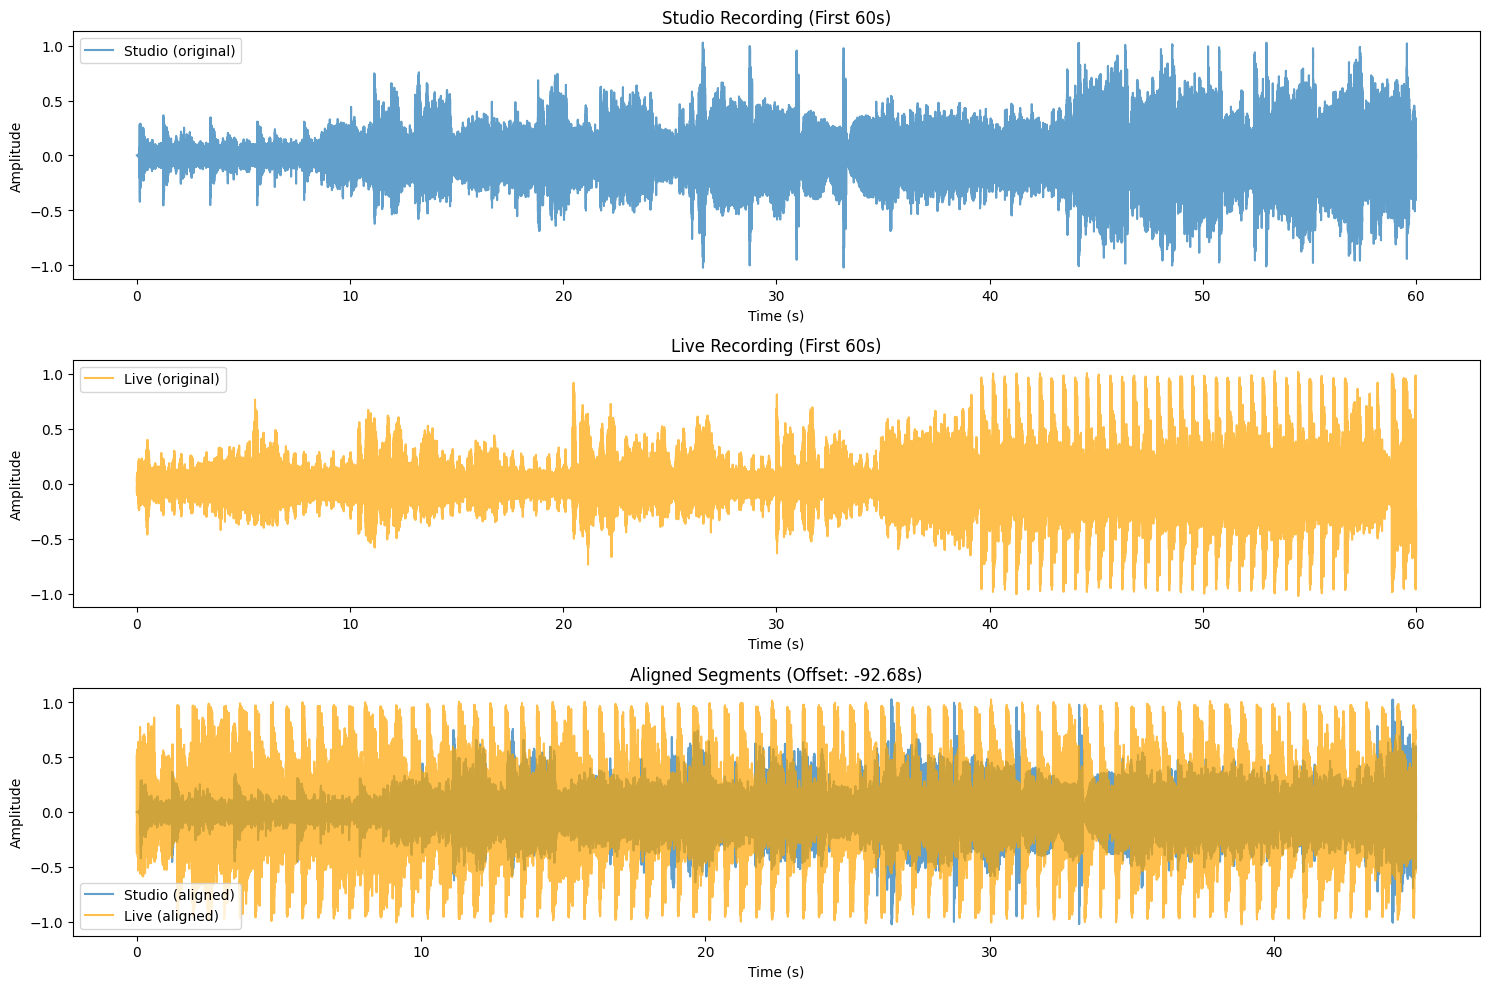

In [6]:
from IPython.display import Audio, display
import numpy as np
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

def find_timestamp_alignment(studio_result, live_result, similarity_threshold=0.6):
    """
    Find alignment offset using timestamped lyrics.
    """
    studio_segments = studio_result['segments']
    live_segments = live_result['segments']
    
    best_matches = []
    
    for studio_seg in studio_segments:
        studio_text = studio_seg['text'].strip().lower()
        if len(studio_text) < 10: 
            continue
            
        best_match = None
        best_score = 0
        
        for live_seg in live_segments:
            live_text = live_seg['text'].strip().lower()
            if len(live_text) < 10:
                continue
                
            similarity = SequenceMatcher(None, studio_text, live_text).ratio()
            
            if similarity > best_score and similarity >= similarity_threshold:
                best_score = similarity
                best_match = {
                    'studio_start': studio_seg['start'],
                    'studio_end': studio_seg['end'],
                    'live_start': live_seg['start'],
                    'live_end': live_seg['end'],
                    'studio_text': studio_text,
                    'live_text': live_text,
                    'similarity': similarity,
                    'time_offset': live_seg['start'] - studio_seg['start']
                }
        
        if best_match:
            best_matches.append(best_match)
    
    if not best_matches:
        print("No matching segments found!")
        return 0, []
    
    offsets = [match['time_offset'] for match in best_matches]
    median_offset = np.median(offsets)
    
    print(f"Found {len(best_matches)} matching lyrical segments")
    print(f"Calculated offset: {median_offset:.2f} seconds")
    print("Top matches:")
    
    best_matches.sort(key=lambda x: x['similarity'], reverse=True)
    for i, match in enumerate(best_matches[:5]):
        print(f"  {i+1}. Similarity: {match['similarity']:.3f}")
        print(f"     Studio: [{match['studio_start']:.1f}s] {match['studio_text'][:50]}...")
        print(f"     Live:   [{match['live_start']:.1f}s] {match['live_text'][:50]}...")
        print(f"     Offset: {match['time_offset']:.2f}s")
        print()
    
    return median_offset, best_matches

def create_aligned_segments(studio_audio, live_audio, offset_seconds, studio_sr, live_sr, segment_duration=30):
    """
    Create aligned audio segments based on calculated offset.
    """
    studio_offset_samples = int(max(0, offset_seconds * studio_sr))
    live_offset_samples = int(max(0, -offset_seconds * live_sr))
    
    if offset_seconds >= 0:
        studio_start = studio_offset_samples
        live_start = 0
    else:
        studio_start = 0
        live_start = live_offset_samples
    
    segment_samples = int(segment_duration * studio_sr)
    studio_segment = studio_audio[studio_start:studio_start + segment_samples]
    live_segment = live_audio[live_start:live_start + int(segment_duration * live_sr)]
    
    return studio_segment, live_segment

print("Performing timestamp-based alignment using lyrics...")
offset_seconds, matches = find_timestamp_alignment(studio_result, live_result)

print(f"\nCreating aligned audio segments...")
studio_aligned, live_aligned = create_aligned_segments(
    studio_audio, live_audio, offset_seconds, studio_sr, live_sr, segment_duration=45
)

print(f"Studio aligned segment: {len(studio_aligned)/studio_sr:.1f} seconds")
print(f"Live aligned segment: {len(live_aligned)/live_sr:.1f} seconds")

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

plot_duration = 60
studio_plot_samples = min(plot_duration * studio_sr, len(studio_audio))
live_plot_samples = min(plot_duration * live_sr, len(live_audio))

time_studio_orig = np.arange(studio_plot_samples) / studio_sr
time_live_orig = np.arange(live_plot_samples) / live_sr

axes[0].plot(time_studio_orig, studio_audio[:studio_plot_samples], alpha=0.7, label='Studio (original)')
axes[0].set_title('Studio Recording (First 60s)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()

axes[1].plot(time_live_orig, live_audio[:live_plot_samples], alpha=0.7, label='Live (original)', color='orange')
axes[1].set_title('Live Recording (First 60s)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].legend()

time_studio_aligned = np.arange(len(studio_aligned)) / studio_sr
time_live_aligned = np.arange(len(live_aligned)) / live_sr

axes[2].plot(time_studio_aligned, studio_aligned, alpha=0.7, label='Studio (aligned)')
axes[2].plot(time_live_aligned, live_aligned, alpha=0.7, label='Live (aligned)', color='orange')
axes[2].set_title(f'Aligned Segments (Offset: {offset_seconds:.2f}s)')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude')
axes[2].legend()

plt.tight_layout()
plt.show()

# Simulairty distribution

In [7]:
import matplotlib.pyplot as plt
import numpy as np

studio_segs = [seg.get('text','').strip() for seg in studio_result.get('segments', []) if seg.get('text','').strip()]
live_segs = [seg.get('text','').strip() for seg in live_result.get('segments', []) if seg.get('text','').strip()]

best_scores = []
best_pairs = []

for s_idx, s_text in enumerate(studio_segs):
    best_score = 0.0
    best_live_idx = None
    for l_idx, l_text in enumerate(live_segs):
        score = lyric_similarity_score(s_text, l_text)['overall_score']
        if score > best_score:
            best_score = score
            best_live_idx = l_idx
    best_scores.append(best_score)
    best_pairs.append((s_idx, best_live_idx, best_score))

best_scores = np.array(best_scores) if best_scores else np.array([])

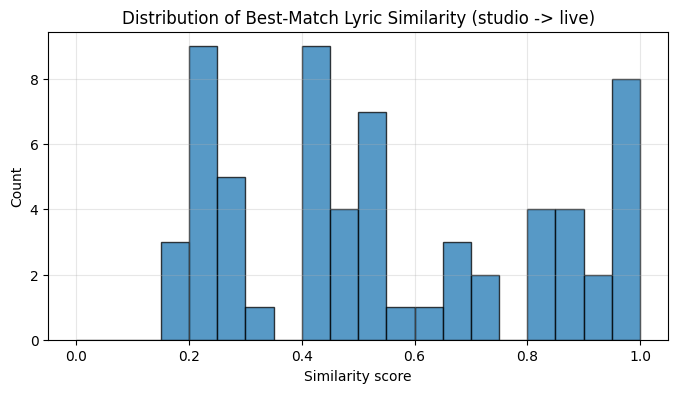

N studio segments: 70
Mean:   0.597
Median: 0.513
Min:    0.168
Max:    1.000


In [8]:
plt.figure(figsize=(8,4))
if best_scores.size > 0:
    plt.hist(best_scores, bins=20, range=(0,1), edgecolor='black', alpha=0.75)
else:
    plt.hist([0], bins=1)

plt.title('Distribution of Best-Match Lyric Similarity (studio -> live)')
plt.xlabel('Similarity score')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

if best_scores.size > 0:
    print(f"N studio segments: {len(best_scores)}")
    print(f"Mean:   {np.mean(best_scores):.3f}")
    print(f"Median: {np.median(best_scores):.3f}")
    print(f"Min:    {np.min(best_scores):.3f}")
    print(f"Max:    {np.max(best_scores):.3f}")
else:
    print('No studio segments found to compute similarities.')

In [9]:
top_n = 5
if best_pairs:
    best_pairs_sorted = sorted(best_pairs, key=lambda x: x[2], reverse=True)
    print('\nTop matched studio->live segments:')
    for i, (s_idx, l_idx, score) in enumerate(best_pairs_sorted[:top_n]):
        s = studio_segs[s_idx]
        l = live_segs[l_idx] if l_idx is not None else ''
        print(f"{i+1}. Score={score:.3f}\n   Studio seg #{s_idx}: '{s[:120]}'\n   Live seg  #{l_idx}: '{l[:120]}'\n")
else:
    print('No matches to display.')


Top matched studio->live segments:
1. Score=1.000
   Studio seg #28: 'Sorry that I broke your heart'
   Live seg  #18: 'Sorry that I broke your heart'

2. Score=1.000
   Studio seg #33: 'Spending money to compensate'
   Live seg  #23: 'Spending money to compensate'

3. Score=1.000
   Studio seg #35: 'Cause I want you baby'
   Live seg  #25: 'Cause I want you baby'

4. Score=1.000
   Studio seg #43: 'Sorry that I broke your heart'
   Live seg  #18: 'Sorry that I broke your heart'

5. Score=1.000
   Studio seg #51: 'I know it's all my fault'
   Live seg  #41: 'I know it's all my fault'



In [10]:
top_n = 5
if best_pairs:
    best_pairs_sorted = sorted(best_pairs, key=lambda x: x[2], reverse=False)
    print('\nWorst matched studio->live segments:')
    for i, (s_idx, l_idx, score) in enumerate(best_pairs_sorted[:top_n]):
        s = studio_segs[s_idx]
        l = live_segs[l_idx] if l_idx is not None else ''
        print(f"{i+1}. Score={score:.3f}\n   Studio seg #{s_idx}: '{s[:120]}'\n   Live seg  #{l_idx}: '{l[:120]}'\n")
else:
    print('No matches to display.')


Worst matched studio->live segments:
1. Score=0.168
   Studio seg #3: 'Without your notice, blue'
   Live seg  #49: 'With the money'

2. Score=0.175
   Studio seg #13: 'It's only our delirium'
   Live seg  #19: 'Your heart'

3. Score=0.178
   Studio seg #1: 'Fighting for my life, I couldn't breathe again'
   Live seg  #22: 'Wasting all of my time I live in my fantasies'

4. Score=0.204
   Studio seg #0: 'I thought I almost died in my dream again'
   Live seg  #11: 'Chose so I can get closer to you inside my dreams'

5. Score=0.212
   Studio seg #8: 'Protection we won't need'
   Live seg  #16: 'Well I am now and I need you close'



In [21]:
from IPython.display import Audio, display

SEGMENT_DURATION = 5.0
MIN_SIMILARITY = 0.3
TOP_N = 3
BOTTOM_N = 3

studio_segments = studio_result.get('segments', [])
live_segments = live_result.get('segments', [])

def clean(t): 
    t = t.strip()
    return t if len(t) >= 5 else None

def normalize(a):
    return a / max(1, np.max(np.abs(a))) if len(a) else a

def extract(audio, center, dur, sr):
    h = dur / 2
    s, e = max(0, center - h), min(len(audio) / sr, center + h)
    return audio[int(s * sr):int(e * sr)]

matches = []
for si, s in enumerate(studio_segments):
    s_text = clean(s.get('text', ''))
    if not s_text: 
        continue

    best = max(
        ((lyric_similarity_score(s_text, clean(l.get('text', '')))['overall_score'], li)
         for li, l in enumerate(live_segments)
         if clean(l.get('text', ''))),
        default=(0, None)
    )

    score, li = best
    if li is not None and score > MIN_SIMILARITY:
        matches.append({
            's_idx': si, 'l_idx': li, 'score': score,
            's_center': (s['start'] + s['end']) / 2,
            'l_center': (live_segments[li]['start'] + live_segments[li]['end']) / 2,
            's_text': s_text,
            'l_text': live_segments[li]['text'].strip()
        })

if not matches:
    print(f'No matched segments with score > {MIN_SIMILARITY}')
    raise SystemExit

matches = sorted(matches, key=lambda x: x['score'], reverse=True)

def show(title, subset):
    print("=" * 60, f"\n{title}\n", "=" * 60, sep="")
    for i, m in enumerate(subset, 1):
        print(f"\nMatch {i}: score={m['score']:.3f}")
        print(f"  Studio #{m['s_idx']}: {m['s_text'][:100]}")
        print(f"  Live   #{m['l_idx']}: {m['l_text'][:100]}")

        s_clip = normalize(extract(studio_audio, m['s_center'], SEGMENT_DURATION, studio_sr))
        l_clip = normalize(extract(live_audio, m['l_center'], SEGMENT_DURATION, live_sr))

        display(Audio(s_clip, rate=studio_sr))
        display(Audio(l_clip, rate=live_sr))
        print("-" * 60)

In [22]:
show(f"TOP {TOP_N} MATCHES", matches[:TOP_N])
show(f"BOTTOM {BOTTOM_N} MATCHES", matches[-BOTTOM_N:])

TOP 3 MATCHES

Match 1: score=1.000
  Studio #28: Sorry that I broke your heart
  Live   #33: Sorry that I broke your heart


------------------------------------------------------------

Match 2: score=1.000
  Studio #33: Spending money to compensate
  Live   #23: Spending money to compensate


------------------------------------------------------------

Match 3: score=1.000
  Studio #35: Cause I want you baby
  Live   #25: Cause I want you baby


------------------------------------------------------------
BOTTOM 3 MATCHES

Match 1: score=0.424
  Studio #64: I said baby
  Live   #35: I say baby


------------------------------------------------------------

Match 2: score=0.400
  Studio #39: Again
  Live   #29: Again


------------------------------------------------------------

Match 3: score=0.308
  Studio #37: It was simply a blessing when I came inside you
  Live   #27: It was simply a pleasure when you've been so few


------------------------------------------------------------
